# Letterboxd movie recommender from scratch

Following https://realpython.com/build-recommendation-engine-collaborative-filtering/

## Imports

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from unidecode import unidecode
try :
    from qbstyles import mpl_style
    mpl_style(dark=True)
    # plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
except :
    plt.style.use("dark_background")


from IPython.display import clear_output
clear_output()

In [30]:
ratings = pd.read_csv(
    "letterboxd_data/ratings_export.csv",
    usecols=["movie_id", "rating_val", "user_id"],
    dtype="str",
    na_filter=False,
)

## Basic stats

In [3]:
print(f"There are {ratings['movie_id'].nunique()} unique movies watched in the database")
print(f"There are {ratings['user_id'].nunique()} unique users in the database")

There are 286072 unique movies watched in the database
There are 7477 unique users in the database


([<matplotlib.axis.XTick at 0x221383bc1f0>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

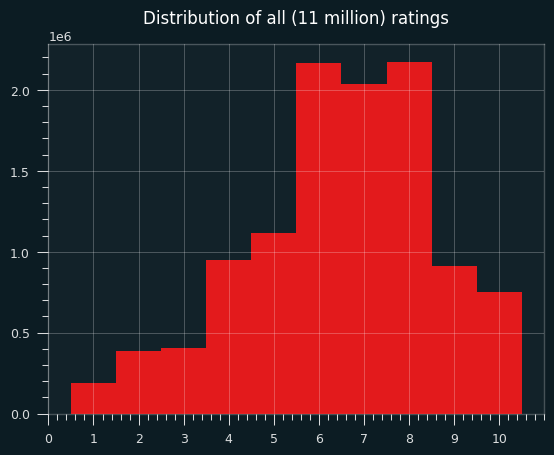

In [31]:
ratings["rating_val"].astype("int").hist(bins=[x + 0.5 for x in range(11)])
plt.title(f"Distribution of all (11 million) ratings")
plt.xticks(list(range(11)))

In [5]:
nb_ratings, users = np.unique(ratings["user_id"], return_counts=True)
nb_movies_per_user = pd.Series(users, nb_ratings).sort_values()
nb_movies_per_user

jukamo               1
lilfilm              1
masonmcenery         1
andrijana            1
dustykramkram        1
                 ...  
imzzzy           21564
loureviews       23654
ghettominibar    26052
punq             32271
acervofilmico    88289
Length: 7477, dtype: int64

The user with the most movies rated is acervofilmico with 88289(!) movies rated.

In [6]:
nb_ratings_by_movie = np.unique(ratings["movie_id"], return_counts=True)
series_nb_ratings_by_movie = pd.Series(*nb_ratings_by_movie[::-1])

## Compute my movies' ids

In [7]:
my_ratings = pd.read_csv("user_data/ratings.csv", usecols=["Name", "Year", "Rating"])
my_ratings["Rating"] = 2*my_ratings["Rating"]
movie_name_fmt = my_ratings["Name"].apply(lambda x : re.sub(r"[^\da-zA-Z-]", "", unidecode(x).lower().replace(" ","-")))
movie_year_fmt = my_ratings["Year"].astype("str")
movie_id_fmt = movie_name_fmt + "-" + movie_year_fmt
my_ratings["movie_name_fmt"] = movie_name_fmt.str.replace(r"-+","-", regex=True)
my_ratings["movie_id_full"] = movie_id_fmt.str.replace(r"-+","-", regex=True)
all_movie_ids = ratings["movie_id"].unique()
my_ratings["movie_id_short_is_official"] = my_ratings["movie_name_fmt"].isin(all_movie_ids)
my_ratings["movie_id_full_is_official"] = my_ratings["movie_id_full"].isin(all_movie_ids)

In [8]:
# movies with ambiguity because of duplicate: several movies with the same name at different (or same) years
duplicate_ids = my_ratings[(my_ratings["movie_id_full_is_official"] * my_ratings["movie_id_short_is_official"])]
my_ratings["movie_id"] = np.where(my_ratings["movie_id_full_is_official"], my_ratings["movie_id_full"], my_ratings["movie_name_fmt"])
movie_duplicated = [movie_id for movie_id in all_movie_ids if any(re.match(rf"^{x}(-\d+)*$", movie_id) for x in duplicate_ids["movie_name_fmt"])]
sorted(movie_duplicated)

[]

In [9]:
unknown_movies = my_ratings.loc[np.logical_and(~my_ratings["movie_id_full_is_official"], ~my_ratings["movie_id_short_is_official"])]
unknown_movies

,Name,Year,Rating,movie_name_fmt,movie_id_full,movie_id_short_is_official,movie_id_full_is_official,movie_id


In [10]:
my_ratings_clean = my_ratings.loc[~my_ratings["movie_id"].isin(unknown_movies["movie_id"])]
my_ratings_clean = my_ratings_clean[["Rating","movie_id"]]
my_ratings_clean

,Rating,movie_id
0,2.0,casablanca
1,4.0,the-godfather
2,7.0,citizen-kane
3,8.0,dawn-of-the-dead
4,10.0,king-kong


## Remove useless data

In [11]:
movies_with_enough_ratings = series_nb_ratings_by_movie[series_nb_ratings_by_movie>10].index
users_with_enough_ratings = nb_movies_per_user[nb_movies_per_user>20].index
ratings_popular = ratings.loc[np.logical_and(ratings["movie_id"].isin(movies_with_enough_ratings), ratings["user_id"].isin(users_with_enough_ratings))]

In [12]:
del ratings

In [13]:
ratings_popular = ratings_popular
ratings_popular["rating_val"] = ratings_popular["rating_val"].astype("float")
mean_rating = ratings_popular.groupby("user_id")["rating_val"].mean()

([<matplotlib.axis.XTick at 0x221003d20d0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

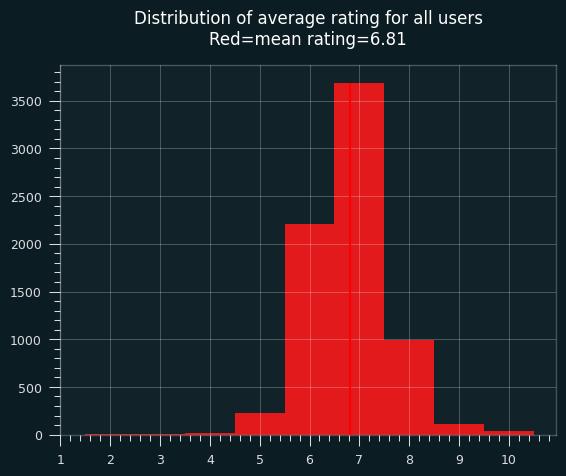

In [14]:
mean_rating.hist(bins=np.arange(1.5,11,1))
plt.vlines(mean_rating.mean(), 0, np.max(np.unique(mean_rating.round(), return_counts=True)[1]), "red")
plt.title(f"Distribution of average rating for all users\nRed=mean rating={mean_rating.mean():.2f}")
plt.xticks(list(range(1,11)))

In [15]:
ratings_popular = pd.merge(ratings_popular,mean_rating, left_on="user_id", right_index=True, suffixes=["","_user_mean"])
ratings_popular["ratings_zero_mean"] = ratings_popular["rating_val"] - ratings_popular["rating_val_user_mean"]
# ratings_popular["ratings_zero_mean"] = ratings_popular["ratings_zero_mean"].astype(np.float32)
ratings_popular

,movie_id,rating_val,user_id,rating_val_user_mean,ratings_zero_mean
0,feast-2014,7.0,deathproof,6.440671,0.559329
1,loving-2016,7.0,deathproof,6.440671,0.559329
2,scripted-content,7.0,deathproof,6.440671,0.559329
3,the-future,4.0,deathproof,6.440671,-2.440671
4,mank,5.0,deathproof,6.440671,-1.440671
...,...,...,...,...,...
11078162,alien-3,6.0,turnitip,6.271147,-0.271147
11078163,battleship-potemkin,7.0,turnitip,6.271147,0.728853
11078164,pusher,6.0,turnitip,6.271147,-0.271147
11078165,wild-strawberries,7.0,turnitip,6.271147,0.728853


## Store data as movie-user sparse table

In [16]:
# adapted from https://stackoverflow.com/a/31679396

from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype

movie_id_u = list(sorted(ratings_popular.movie_id.unique()))
user_id_u = list(sorted(ratings_popular.user_id.unique()))

# data = ratings_popular['ratings_zero_mean'].tolist()
data = ratings_popular['rating_val'].tolist()
cat_type_movie = CategoricalDtype(categories=movie_id_u, ordered=True)
cat_type_user = CategoricalDtype(categories=user_id_u, ordered=True)
row = ratings_popular.movie_id.astype(cat_type_movie).cat.codes
col = ratings_popular.user_id.astype(cat_type_user).cat.codes
sparse_matrix = csr_matrix((data, (row, col)), shape=(len(movie_id_u), len(user_id_u)), dtype=np.float32)

In [17]:
del data
del col
del row

In [18]:
movie_user_table = pd.DataFrame.sparse.from_spmatrix(sparse_matrix, index=movie_id_u, columns=user_id_u, )

movie_user_table["placeholder_username"] = pd.Series(my_ratings_clean["Rating"].values, index=my_ratings_clean["movie_id"])
movie_user_table = movie_user_table.astype(pd.SparseDtype(np.float32, fill_value=np.nan))
movie_user_table_zero_mean = movie_user_table - movie_user_table.mean(axis=0)

## Compute similarity with you

In [19]:
def norm(A):
    return np.sqrt(np.sum(A**2,axis=0))

norm_product = norm(movie_user_table_zero_mean["placeholder_username"]) * (norm(movie_user_table_zero_mean))

In [20]:
ratings_popular

,movie_id,rating_val,user_id,rating_val_user_mean,ratings_zero_mean
0,feast-2014,7.0,deathproof,6.440671,0.559329
1,loving-2016,7.0,deathproof,6.440671,0.559329
2,scripted-content,7.0,deathproof,6.440671,0.559329
3,the-future,4.0,deathproof,6.440671,-2.440671
4,mank,5.0,deathproof,6.440671,-1.440671
...,...,...,...,...,...
11078162,alien-3,6.0,turnitip,6.271147,-0.271147
11078163,battleship-potemkin,7.0,turnitip,6.271147,0.728853
11078164,pusher,6.0,turnitip,6.271147,-0.271147
11078165,wild-strawberries,7.0,turnitip,6.271147,0.728853


In [21]:
dot_product = movie_user_table_zero_mean["placeholder_username"].fillna(0.).dot(movie_user_table_zero_mean.fillna(0.))

In [22]:
del movie_user_table_zero_mean

In [23]:
similarities = ((1+dot_product / norm_product.astype(np.float32))/2).astype(np.float32)
similarities.drop("placeholder_username", inplace=True)
similarities.sort_values(ascending=False, inplace=True)
similarities.fillna(0., inplace=True)

dissimilarities = 1 - similarities
similarity_rank = dissimilarities.argsort()
similarity_rank

ssens                 0
sleevelesssocks       1
kittophoenix          2
hokandil              3
miriamblaylocks       4
                   ... 
othavio232         7281
planetclaires      7293
unclenugget        7279
wyattduncan        7285
xico5689           7294
Length: 7295, dtype: int64

## Rank users by similarity in rating database

In [24]:
user_movie_table = movie_user_table.T

In [25]:
ratings_popular_sorted=pd.DataFrame(data=ratings_popular["rating_val"].values, index=pd.MultiIndex.from_frame(ratings_popular[["movie_id","user_id"]])).rename(columns={0:"rating"})

def sorter(s):
    if s.name == "user_id":
        return s.map({k:similarity_rank[k] for k in s})
    return s

ratings_popular_sorted.sort_index(key=sorter, inplace=True)
ratings_popular_sorted

rating
movie_id                              user_id              
00-08                                 rovhul            5.0
                                      benpatten02       6.0
                                      akabsb            4.0
                                      selaserviette     9.0
                                      shikhar           5.0
...                                                     ...
zz-top-that-little-ol-band-from-texas arnoldfurious     8.0
                                      calum             6.0
                                      ddarko42          8.0
                                      davidraider88     6.0
                                      onemarathon       8.0

[10461930 rows x 1 columns]

## For every movie extract close users only

In [26]:
nb_similar_users = 20

movies_list = ratings_popular_sorted.index.get_level_values(0)
similar_users_per_movie = {movie:[] for movie in set(movies_list)}
for idx, movie in enumerate(movies_list) :
    if len(similar_users_per_movie[movie]) < nb_similar_users:
        similar_users_per_movie[movie].append(idx)

index_sim_users_per_movie = []
for idx in similar_users_per_movie.values() :
    index_sim_users_per_movie += idx

In [27]:
ratings_popular_close_users = ratings_popular_sorted.iloc[index_sim_users_per_movie].sort_index(key=sorter)

## Simple avearge

In [28]:
final_predictions = ratings_popular_close_users.groupby("movie_id").mean().sort_values("rating", ascending=False)
seen_movies = my_ratings_clean["movie_id"]
final_predictions = final_predictions.filter(items=[movie for movie in final_predictions.index if movie not in seen_movies.values], axis=0)
final_predictions.index = final_predictions.index.map(lambda x : x.replace("-"," ").capitalize())
final_predictions["rating"] = final_predictions["rating"].apply(lambda x : f'{x/2:.3f}/5')
final_predictions.iloc[:25]

,rating
Parasite 2019,4.825/5
The lord of the rings collection,4.800/5
Mr robot decoded,4.775/5
Compasso de espera,4.769/5
Cosmos a personal voyage,4.750/5
National theatre live present laughter,4.750/5
Queen live at wembley stadium,4.725/5
My mister,4.722/5
How to with john wilson,4.711/5
Beyonce self titled,4.708/5
